**Machine Learning Basic Principles 2018 - Data Analysis Project Report. Group 256, Mathias Smeds and Mathias Fontell**

# *Title* 

*Title should be concise and informative, describes the approach to solve the problem. Some good titles from previous years:*

*- Comparing extreme learning machines and naive bayes’ classifier in spam detection*

*- Using linear discriminant analysis in spam detection*

*Some not-so-good titles:*

*- Bayesian spam filtering with extras*

*- Two-component classifier for spam detection*

*- CS-E3210 Term Project, final report*




## Abstract

*Precise summary of the whole report, previews the contents and results. Must be a single paragraph between 100 and 200 words.*



## 1. Introduction (SMEDS)

*Background, problem statement, motivation, many references, description of
contents. Introduces the reader to the topic and the broad context within which your
research/project fits*

*- What do you hope to learn from the project?*
*- What question is being addressed?*
*- Why is this task important? (motivation)*

*Keep it short (half to 1 page).*

.-.-.-.-.-.-.-.-

Assigning a genre to a song is a task at which even humans might have different opinions as to what is the correct genre. Thus we can expect that teaching a computer to correctly predict a genre for a given song is no easy feat.

Our task is to teach a computer to assign a genre to a song, based on data features extracted from the song. The two most important outcomes from this project are

1. How well can a computer predict the genre of a song based on simple Machine Learning algorithms
2. What preprocessing of the data is needed

We have two datasets consisting of song features, with one of the datasets being labeled to specific genres. Depending on the bitrate and audio format a single song can be several tens of megabytes, with normal listening bitrate for an mp3-file requiring at least a few megabytes. This means that using all bits in the song would result in a huge dataset impractical for our purposes. Because of this we have a dataset consisting of features engineered from the song, so that one song does not take up too much storage and computational resources.

The project consists of preprocessing the data and finding a training a predictor which performs well both in assigning each song a genre as well as having good confidence in that assignment.

Googling "machine learning song genre" gives almost 8 million hits. It seems to be an interesting problem for developing ML algorithms, maybe because of it being hard to perform better than humans. Perhaps the most popular machine learning solution for music is tha Shazam-app which can come up with a song title based on a sample from a song. Even though Shazam is not centered around finding good accurate genre labels for songs, it is still close enough to this project to show that applying Machine Learning to music is relevant both for business and science purposes.



## 2. Data analysis (FONTELL)

### 2.1. Overview of the data

Before diving headfirst into classification and any derived machine earning (pun intended), we are well advised to familiarize ourselves with the data at hand. There are several reasons for doing this. First of all, identifying significant features or redundancy helps in finding a machine learning method most suitable for the data; the difference between trends that appear linear, polynomial, clustered or something completely alien can single out certain methods from the getgo. Moreover, filtering out redundant features improves the speed and often the accuracy of the selected classifier. As such, this section is tasked with addressing the following questions:

    - How are the classes distributed in the data? Is there a major representation of some classes?
    - What are the feature ranges, and is some pattern evident in the data?
    - Can the dimensionality of the data be reduced for improved speed and accuracy?

The songs in the dataset have been preprocessed into vectors of 264 features. The features contain information about the rhytm pattern, chroma and Mel Frequency Cepstral Coefficients (MFCC). Although a prior understanding of the technical details would certainly be useful, the conversion of an audio file into the MFCCs and rhythm/chroma patters is rather technical and well beyond the scope of this project. An overview of the procedure is presented in [1]; here we will not dwelve further into the details of the features. First, we start with investigating the class distribution.

Run the cell below to import the data and plot a histogram of the class distribution.

C:\Users\Mathias\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Users\Mathias\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Users\Mathias\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


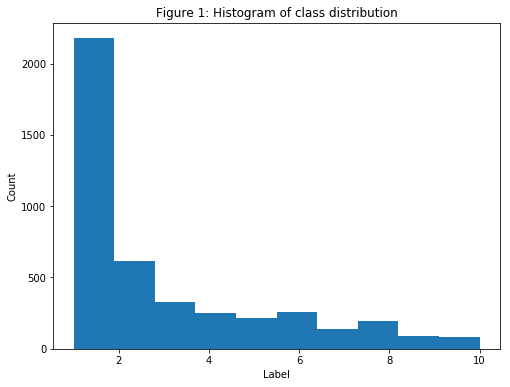

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
import random
from random import randint
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import StandardScaler

# Load the data and cleanup
train_data = pd.read_csv("train_data.csv", header=None).as_matrix()
test_data = pd.read_csv("test_data.csv", header=None).as_matrix()
train_labels = pd.read_csv("train_labels.csv", header=None).as_matrix()


#Histogram of class distribution
fig=plt.figure(figsize=(8,6))
plt.hist(train_labels[:,0])
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Figure 1: Histogram of class distribution')
plt.show()

The histogram figure 1 shows that of the circa 4300 songs in the training dataset, almost 2000 represent label 1 i.e. pop. This appears to be a textbook example of an imbalanced dataset for classification; of the training labels, a disproportionate amount represent some label while some labels are wildly underrepresented. In the cells below, we present a function for undersampling a known genre by random selection to combat the imbalance. However, we will find out that this form of undersampling is not helpful - in fact, pop songs are so ubiquitous in any dataset we are likely to encounter, that we'd be well off trying to train our machine to at least classify pop songs correctly. Despite efforts, we have not found a way of undersampling the set without a reduction in the validation error. This will be elaborated on momentarily.

### 2.2. Features and range of variables

Then to the actual features. While the technical details of the features are rather complicated, it is prudent to at least investigate the feature range. In the cell below, we present scatter plots of a few selected column to better illuminate the data at hand. Run it to see what unfolds!

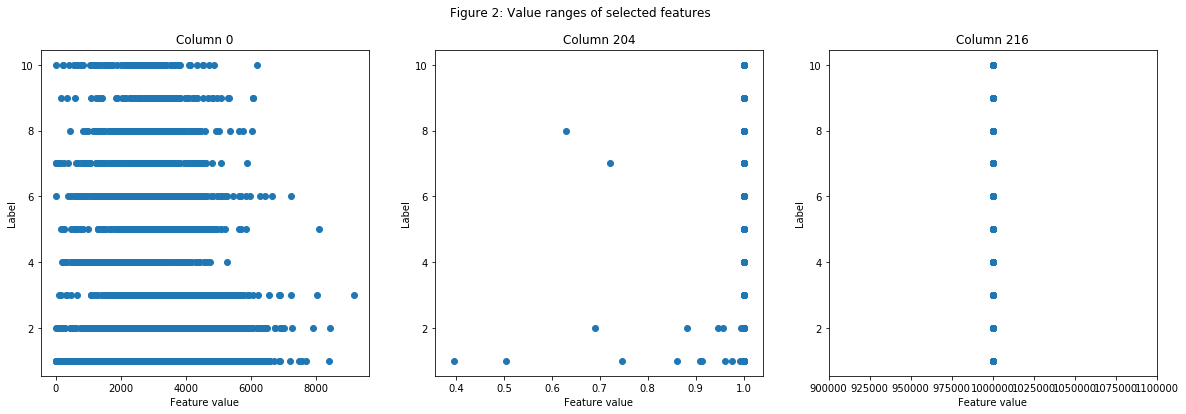

In [12]:
fig=plt.figure(figsize=(8,6))
fig.suptitle('Figure 2: Value ranges of selected features')
fig.set_figwidth(20)

plt.subplot(1,3,1)
plt.scatter(train_data[:,0],train_labels.ravel())
plt.title('Column 0')
plt.xlabel('Feature value')
plt.ylabel('Label')

plt.subplot(1,3,2)
plt.scatter(train_data[:,204],train_labels.ravel())
plt.title('Column 204')
plt.xlabel('Feature value')
plt.ylabel('Label')

plt.subplot(1,3,3)
plt.scatter(train_data[:,216],train_labels.ravel())
plt.title('Column 216')
plt.xlabel('Feature value')
plt.ylabel('Label')
plt.xlim([0.9e6,1.1e6])

Upon closer inspection of figure 2, one notices that tha value ranges differ by several orders of magnitude. As an example, the first column of features (leftmost graph in figure 2) spans over several thousands, while the 205th column (middle graph) contains values strictly less than unity. Moreover, all the values in the 217th column (rightmost graph) are equal to $10^{6}$. These findings present two necessary courses of action: Scaling of the data, and dimension reduction. Feature scaling refers to the practice of normalizing the data to a certain range without loss of information. This practice proves to improve the performance of most machine learning methods [2], and will be presented in the cell below. Secondly, as some columns (e.g. column 216, rightmost graph in figure 2) contain values that are identical, the entire features corresponding to these columns are redundant and can be left out of the training set. This practice is known as dimensionality reduction, and improves the performance of machine learnin methods by decreasing the risk of overfitting as well as reducing the time of computation and memory requirements.

### 2.3. Feature scaling and dimensionality reduction

The cell below walks through the process of scaling the columns to a range $\in [0,1]$ for improved performance. In addition, we present a subroutine for randomly undersampling the data to combat class imbalance.

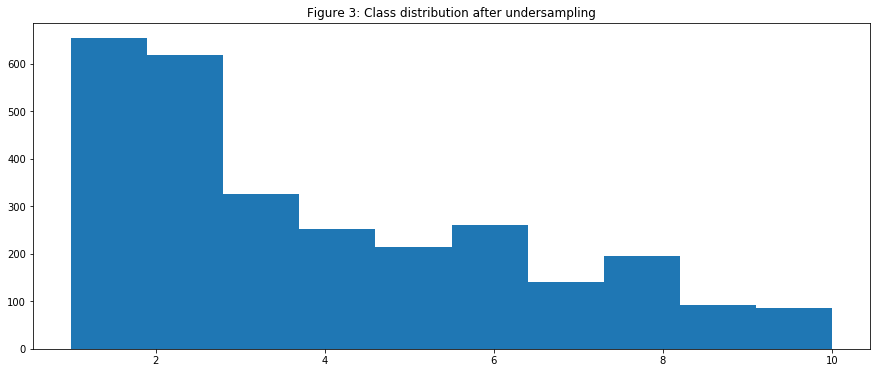

In [15]:
#normalize the data: support vector machines work better this way
from sklearn.preprocessing import MinMaxScaler

#The function my_minmaxscaler presents a possible implementation of scaling columns to a range [0,1]
#This function is omitted in favor of Python library functions for doing the same thing
def my_minmaxscaler(input_data):
    #Input: N x D matrix 'input_data' to be normalized
    #Output N x D matrix 'scaled_data', for which the columns j [0,D-1] have been normalized to [0,1] by the minmax procedure
    scaled_data=input_data
    for j in range(input_data.shape[1]):
        col=input_data[:,j]
        col_min=np.min(col)
        col_max=np.max(col)
    if(col_min==col_max):
        for i in range(input_data.shape[0]):
            scaled_data[i,j]=1.0
    else:
        for i in range(scaled_data.shape[0]):
            scaled_data[i,j]=(scaled_data[i,j]-col_min)/(col_max-col_min)
    return scaled_data

#We use the Python MinMaxScaler() instead
#We have found, that the method exhibits inexplicable floating point errors: some maxima are e.g. 0.999 or 1.002
#when supposed to be exactly 1.0
norm_data=MinMaxScaler().fit_transform(train_data)
norm_data_test=MinMaxScaler().fit_transform(test_data)

#Below is a possible implementation of an undersampling subroutine for randomly selecting some rows corresponding to 
#one genre to be left out of the data. We have found, that this does not help: see section 3 for results
def undersample_genre(features, labels, remaining, genre):
#Input: N x D features matrix, N x 1 labels matrix, remaining percentage of rows corresponding to label genre
#Output: (remaining*N) x D features matrix, (remaining*N) x 1 labels matrix
#remove some of those damn pop songs randomly
    N_data=features.shape[0]
    N_genre=0
    for i in range(N_data):
        if(labels[i]==genre):
            N_genre+=1
            
    to_delete=int(np.floor((1.0-remaining)*N_genre))
    deleted=0
    while(deleted<to_delete):
        #pick random row in tdata
        rand_row=randint(0, features.shape[0]-1)
        if(labels[rand_row]==genre):
            rand=random.uniform(0, 1)
            if(rand>remaining):
                #remove this row from tdata
                features = np.delete(features, (rand_row), axis=0)
                labels = np.delete(labels, (rand_row), axis=0)
                deleted+=1
    return features, labels

#Randomly remove 70% of the rows corresponding to label 1
undersampled_data, undersampled_labels = undersample_genre(train_data, train_labels, 0.3, 1)


fig=plt.figure(figsize=(8,6))
fig.set_figwidth(15)
plt.hist(undersampled_labels)
plt.title('Figure 3: Class distribution after undersampling')
plt.show()



moi

/Users/mathias/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


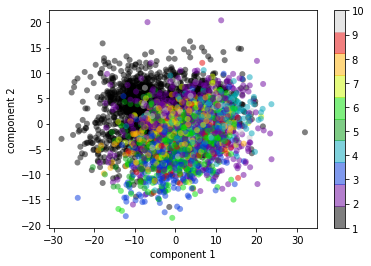

In [69]:
#Analysis of the input data: MATTI
#TODO: Counteract imbalance in data set

N=norm_data.shape[0]
C = np.cov(np.transpose(norm_data)) #data=normalize training data
values, vectors = np.linalg.eig(C)
idx = (values.real).argsort()[::-1]   
values_sorted = (values[idx]).real
vectors_sorted = vectors[:,idx]

#test principal component analysis of data

data_for_PCA = StandardScaler().fit_transform(train_data)
data_for_PCA_test = StandardScaler().fit_transform(test_data)
pca = PCA(.97)
pca_data = pca.fit_transform(data_for_PCA)
pca_test_data = pca.fit_transform(data_for_PCA_test)

plt.scatter(pca_data[:, 0], pca_data[:, 1],
            c=train_labels.ravel(), edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();


lda = LDA(n_components=10)
lda.fit(norm_data,train_labels.ravel())
lda_data=lda.transform(norm_data)
lda_data_test=lda.transform(norm_data_test)




#Output for classification
# train_data, test_data
# norm_data, norm_test_data
# pca_data, pca_test_data (normalised)
# lda_data, lda_test_data (normalised)
# undersampled_data, undersamples_test_data

 

Finally we try a manual solution for choosing the best columns to include. By inspection we notice that columns 204-219 have almost all data points as the same value throughout each column. We drop these columns from the normalized data and keep the reduced dataset as a new feature-matrix.

In [58]:
manual_data = np.delete(norm_data, np.s_[204:219], 1)
manual_test_data = np.delete(norm_data_test, np.s_[204:219], 1)

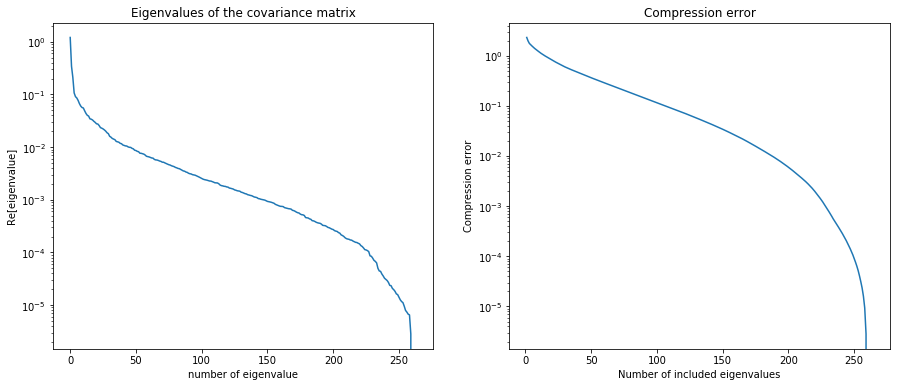

In [6]:
D=values_sorted.shape[0]
compression_error=np.zeros((1,D))
number_included=np.zeros((1,D))
for i in range(D):
    sum=0
    for j in range(i+1,D):
        sum+=values_sorted[j]
    compression_error[0,i]=sum
    number_included[0,i]=i+1
  
fig=plt.figure(figsize=(8,6))
fig.set_figwidth(15)
plt.subplot(1,2,1)
plt.plot(values_sorted[:])
plt.xlabel('number of eigenvalue')
plt.semilogy()
plt.ylabel('Re[eigenvalue]')
plt.title("Eigenvalues of the covariance matrix")

plt.subplot(1,2,2)
plt.plot(number_included[0,:],compression_error[0,:])
plt.xlabel('Number of included eigenvalues')
plt.semilogy()
plt.ylabel('Compression error')
plt.title("Compression error")
plt.show()

## 3. Methods and experiments (MATTE)

We started out by testing a few classifiers from scikit-learn.
- linear_model.LinearRegression
- linear_model.BayesianRidge
- sklearn.neural_network.MLPClassifier
- sklearn.svm.SVC
- sklearn.ensemble.RandomForestClassifier

On our full dataset without any modifications we got varied scoring on the training data. From about 30% with linear regression to 100% on Random Forest (which is obviously very overfitted). Because of the amount of code needed to show the intermediate results these are left out.

Out of these SVM and Random Forest seemed to be the most promising. We had two main options from here, try to find the best classifier by trial and error or try to get better results by understanding the data better. We decided that in order to learn the most from the project it would be useful to understand the data and what we can do with it, rather than blindly trying new classifiers until we would find improvement.

Understanding the data is explained in section 2 above. From section 2 we have an input of 5 different ways that we have processed the dataset.

- Full dataset
- Normalised dataset
- PCA-transformed dataset
- LDA-transformed dataset
- Undersampled dataset



In [46]:
#train_data, test_data
# norm_data, norm_data_test
# pca_data, pca_test_data (normalised)
# lda_data, lda_test_data (normalised)
# undersampled_data, undersamples_test_data
# manual_data, manual_test_data

As mentioned above it was easy to get very high training accuracy using a deep enough Random Forest, but that obviously did not yield good scores when submitting to kaggle. To get a reasonable guess on how to set up the Random Forest algorithm we can make use of cross validation as well as grid search.

In the cell below we do a grid search over 25 different parameter setups to find the best options for the Random Forest classifier. We find parameters using the LDA-transformed dataset, since it is significantly faster than using the full dataset. We choose 5-fold cross validation, which means that for each parameter setup the data is split and tested 5 times.

The grid search with cross validation is doing heavy calculations. This means that the cell below takes a while to run. 

Running the grid search multiple times gives varied best parameters. Printing out the results for all runs shows that the mean score improves until a certain point and stops improving after that. This suggests that we are possibly starting to overfit the data even despite the cross validation. 

This seems to occur at a max depth of 10 and with 100 estimators. We manually refit the Random Forest classifier using these parameters.

In [38]:
#Set up random forest classifier
rfc = RandomForestClassifier()

#Set up grid for which setups to test
param_grid = {'n_estimators': [40, 60, 80, 100, 120], 'max_depth': [4, 6, 8, 10, 12]}

#Do grid search with 10-fold cross validation
grid_rfc = GridSearchCV(rfc, param_grid, cv=5)
grid_rfc.fit(lda_data, train_labels.ravel())
print(grid_rfc.grid_scores_)



In [67]:
#Fit classifier to different permutations of dataset (Note: Cell may take a few minutes to run)
rfc = RandomForestClassifier(n_estimators=100, max_depth = 10).fit(train_data, train_labels.ravel())
rfc_norm = RandomForestClassifier(n_estimators=100, max_depth = 10).fit(norm_data, train_labels.ravel())
rfc_pca = RandomForestClassifier(n_estimators=100, max_depth = 10).fit(pca_data, train_labels.ravel())
rfc_lda = RandomForestClassifier(n_estimators=100, max_depth = 10).fit(lda_data, train_labels.ravel())
rfc_undersampled = RandomForestClassifier(n_estimators=100, max_depth = 10).fit(undersampled_data, undersampled_labels.ravel())
rfc_manual = RandomForestClassifier(n_estimators=100, max_depth = 10).fit(manual_data, train_labels.ravel())


In [68]:
#(Note: Cell may take a few minutes to run)
print("Cross validated Random Forest scores on test data\n") 
print("Full data score: ", np.mean(cross_val_score(rfc, train_data, train_labels.ravel(), cv=5)))
print("Normalised data score: ", np.mean(cross_val_score(rfc_norm, norm_data, train_labels.ravel(), cv=5)))
print("LDA data score: ", np.mean(cross_val_score(rfc_lda, lda_data, train_labels.ravel(), cv=5)))
print("PCA data score: ", np.mean(cross_val_score(rfc_pca, pca_data, train_labels.ravel(), cv=5)))
print("Undersampled data score: ", np.mean(cross_val_score(rfc_undersampled, undersampled_data, undersampled_labels.ravel(), cv=5)))
print("Manual data score: ", np.mean(cross_val_score(rfc_manual, manual_data, train_labels.ravel(), cv=5)))

Cross validated Random Forest scores on test data

Full data score:  0.5883338699780432
Normalised data score:  0.5894861715390893
LDA data score:  0.7180789687802029
PCA data score:  0.5484611811578314
Undersampled data score:  0.5234987704675385
Manual data score:  0.5906196058248747


At this point it looks like we have a very clear winner in the LDA data. Unfortunately it doesn't perform nearly as well on kaggle. The rest of the classifiers seem to have similar cross validation scores to the corresponding real kaggle results.

Based on this we choose the full dataset without modifications for the final classifier and output.

In [61]:
#Final algorithm output
rfc_output_accuracy = rfc.predict(test_data)
rfc_output_logloss = rfc.predict_proba(test_data)

## 4. Results (Output: Smeds, Confusion matrix: Fontell)

*Summarize the results of the experiments without discussing their implications.*

*- Include both performance measures (accuracy and LogLoss).*

*- How does it perform on kaggle compared to the train data.*

*- Include a confusion matrix.*



Our experiments showed that the best cross validated performance was using LDA-sampled data. However, this was a false positive since the actual performance on Kaggle was significantly less. On Kaggle we got around 59% performance with out best classifier. The cross validation score is also 59% for this, which suggests that cross validation can be a good indicator of the real-world performance of a classifier.


In [60]:
#TODO Confusion matrix ...

#Output for Accuracy competition
output_csv = pd.DataFrame({'Sample_label': rfc_output_accuracy})
output_csv.index += 1
output_csv.index.names = ['Sample_id']

#Output for Logloss competition
output_csv2 = pd.DataFrame(rfc_output_logloss, columns=['Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5','Class_6','Class_7','Class_8','Class_9','Class_10',])
output_csv2.index += 1
output_csv2.index.names = ['Sample_id']

#output_csv.rename({1: "Sample_id", 2: "Sample_label"}, index=)
output_csv.to_csv('upload_to_kaggle_accuracy.csv')
output_csv2.to_csv('upload_to_kaggle_logloss.csv')


## 5. Discussion/Conclusions

*Interpret and explain your results *

*- Discuss the relevance of the performance measures (accuracy and LogLoss) for
imbalanced multiclass datasets. *

*- How the results relate to the literature. *

*- Suggestions for future research/improvement. *

*- Did the study answer your questions? *



We had expected to find significant improvement by understanding the data better, but were not able to convert the data-analysis into a better score.

We were not able to find a good explanation for the big difference in LDA cross validation versus real world performance.

On another note, oispa kaljaa. [3]

## 6. References

[1] N.M. Patil, M.U. Nemande: "Music Genre Classification Using MFCC, K-NN and SVM Classifier". International Journal of Computer Engineering In Research Trends, Vol. 4, Issue 2, pp 43-47, 2017.
[2] S. Tsakalidis, V. Doumpiotis and W. Byrne, "Discriminative Linear Transforms for Feature Normalization and Speaker Adaptation in HMM Estimation". Proc. ICSLP 02, 2003.
[3] B. Atman, S.U. Perman, "I am impressed you are actually checking the references: References [1]-[2] are legitimate though". Journal of Vanity and Boredom, Vol. 0, pp. 4-20, 200 B.C. 

## Appendix
*Any additional material needed to complete the report can be included here. For example, if you want to keep  additional source code, additional images or plots, mathematical derivations, etc. The content should be relevant to the report and should help explain or visualize something mentioned earlier. **You can remove the whole Appendix section if there is no need for it.** *